## **Deep Q-Network for Resource Scaling**
**A DQN agent is used to decide whether to scale up, scale down, or take no action.**

1. Import libraries

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error

2. Define RL environment

In [32]:
#Define the RL Environment using CSV datasets with a fixed reward function.
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="reduced_ec2_data.csv", 
                 rds_file="reduced_rds_data.csv", 
                 ecs_file="reduced_ecs_data.csv"):
        # Load CSV files and select the appropriate CPU utilization column,
        # converting values to floats and filling missing values with 0.
        self.ec2_data = pd.read_csv(ec2_file)["EC2_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values
        self.rds_data = pd.read_csv(rds_file)["RDS_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values
        self.ecs_data = pd.read_csv(ecs_file)["ECS_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values

        # Use the shortest dataset length for a consistent episode length.
        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data))
        self.state_size = 3  # one value per service
        self.action_size = 3  # 0: scale up, 1: scale down, 2: no action
        # Set target utilization lower than the typical base value (e.g., 0.4)
        self.target = np.array([0.4, 0.4, 0.4])
        self.index = 0
        self.effect = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(self.state_size)
        base_state = np.array([self.ec2_data[self.index], 
                               self.rds_data[self.index], 
                               self.ecs_data[self.index]])
        state = np.clip(base_state + self.effect, 0, 1)
        return state
    
    def step(self, action):
        # Modify the effect based on action:
        # Scale Up (action 0): reduces effective utilization (subtract 0.1)
        # Scale Down (action 1): increases effective utilization (add 0.1)
        # No Action (action 2): leaves effect unchanged.
        if action == 0:
            self.effect -= 0.1
        elif action == 1:
            self.effect += 0.1

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1  # Clamp to last index
        
        base_state = np.array([self.ec2_data[self.index], 
                               self.rds_data[self.index], 
                               self.ecs_data[self.index]])
        state = np.clip(base_state + self.effect, 0, 1)
        # Compute reward as negative average absolute error from the target, scaled by 3.
        reward = -3 * np.mean(np.abs(state - self.target))
        return state, reward, done

3. Defining DQN

In [33]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

4. Define the DQN Agent with a target network and gradient clipping

In [34]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.98          # discount factor
        self.epsilon = 1.0         # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.998
        self.learning_rate = 0.0003  # lowered learning rate
        self.model = DQN(state_size, action_size)
        # Create a target network and initialize it with the same weights.
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.model(state_tensor)
        return torch.argmax(action_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                # Use the target network for a more stable target calculation.
                target = reward + self.gamma * torch.max(self.target_model(next_state_tensor)).item()
            predicted = self.model(state_tensor)[0][action]
            loss = self.criterion(predicted, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            # Clip gradients to stabilize training.
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

5. Main Training Loop 

In [35]:
def train_rl_agent(episodes=2000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size, env.action_size)
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        # Update target network every 25 episodes.
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step  # average reward per step
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")

6. Evaluate the Trained RL Agent

In [36]:
def evaluate_rl_agent(episodes=100):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size, env.action_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            action_counts[action] += 1
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    return overall_avg, action_distribution, mae, mse, rmse



7. Run training and evaluation

In [37]:

if __name__ == "__main__":
    train_rl_agent()
    evaluate_rl_agent()

FileNotFoundError: [Errno 2] No such file or directory: 'reduced_ec2_data.csv'

Testing

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gym
from gym import spaces

# 1. Updated Environment Class with Modified Reward Function
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="../reduced_ec2_data.csv", 
                 rds_file="../reduced_rds_data.csv", 
                 ecs_file="../reduced_ecs_data.csv"):
        # Load CSV files and select the appropriate CPU utilization column.
        # Convert values to float and fill missing values with the column's mean.
        df_ec2 = pd.read_csv(ec2_file)
        self.ec2_data = pd.to_numeric(df_ec2["EC2_CPUUtilization"], errors='coerce')
        self.ec2_data.fillna(self.ec2_data.mean(), inplace=True)
        self.ec2_data = self.ec2_data.values

        df_rds = pd.read_csv(rds_file)
        self.rds_data = pd.to_numeric(df_rds["RDS_CPUUtilization"], errors='coerce')
        self.rds_data.fillna(self.rds_data.mean(), inplace=True)
        self.rds_data = self.rds_data.values

        df_ecs = pd.read_csv(ecs_file)
        self.ecs_data = pd.to_numeric(df_ecs["ECS_CPUUtilization"], errors='coerce')
        self.ecs_data.fillna(self.ecs_data.mean(), inplace=True)
        self.ecs_data = self.ecs_data.values

        # Use the shortest dataset length for a consistent episode.
        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data))
        self.state_size = 3  # one value per service
        
        # Define action space as MultiDiscrete: each service has 3 possible actions.
        # 0: Scale Up, 1: Scale Down, 2: No Action.
        self.action_space = spaces.MultiDiscrete([3, 3, 3])
        
        # Define the ideal utilization and acceptable SLA bounds.
        self.ideal = np.array([0.5, 0.5, 0.5])
        self.lower_bound = np.array([0.4, 0.4, 0.4])
        self.upper_bound = np.array([0.7, 0.7, 0.7])
        
        self.index = 0
        # effect is applied per service to adjust the effective CPU usage.
        self.effect = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(self.state_size)
        base_state = np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ])
        state = np.clip(base_state + self.effect, 0, 1)
        return state
    
    def step(self, action):
        """
        action: an array of three integers (one per service):
                0 = Scale Up, 1 = Scale Down, 2 = No Action.
        """
        # Current effective state before applying action.
        current_state = np.clip(np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ]) + self.effect, 0, 1)
        
        # Process each service independently.
        new_effect = self.effect.copy()
        for i, act in enumerate(action):
            if act == 0:  # Scale Up: reduce effective utilization if above ideal.
                diff = current_state[i] - self.ideal[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff  # Increased adjustment factor.
                new_effect[i] -= adjustment
            elif act == 1:  # Scale Down: increase effective utilization if below ideal.
                diff = self.ideal[i] - current_state[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff
                new_effect[i] += adjustment
            # act == 2: no action.
        self.effect = new_effect

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1  # Clamp to last index.

        base_state = np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ])
        state = np.clip(base_state + self.effect, 0, 1)
        
        # Compute the error relative to the ideal state.
        error = np.mean(np.abs(state - self.ideal))
        threshold = 0.1

        # Reward calculation:
        if error <= threshold:
            base_reward = (threshold - error) * 20  
        else:
            base_reward = - (error - threshold) * 5  #
        bonus = 1.0 if (np.all(state >= self.lower_bound) and np.all(state <= self.upper_bound)) else 0.0
        reward = base_reward + bonus + 2.0  
        
        return state, reward, done

# 2. Define the Multi-Head DQN Network for three services.
class DQN(nn.Module):
    def __init__(self, state_size, hidden_dim=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Three separate output heads, one per service.
        self.head_ec2 = nn.Linear(hidden_dim, 3)
        self.head_rds = nn.Linear(hidden_dim, 3)
        self.head_ecs = nn.Linear(hidden_dim, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_ec2 = self.head_ec2(x)  # shape: [batch, 3]
        q_rds = self.head_rds(x)  # shape: [batch, 3]
        q_ecs = self.head_ecs(x)  # shape: [batch, 3]
        return q_ec2, q_rds, q_ecs

# 3. Define the DQN Agent for multi-discrete action space.
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        # Action space for each service: 3 actions.
        self.action_space = [0, 1, 2]
        self.memory = deque(maxlen=5000)
        self.gamma = 0.98          # Discount factor.
        self.epsilon = 1.0         # Exploration rate.
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.998
        self.learning_rate = 0.0003
        self.model = DQN(state_size).float()
        self.target_model = DQN(state_size).float()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        # Action is a numpy array of 3 integers.
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # For multi-discrete, choose an action for each service.
        if np.random.rand() <= self.epsilon:
            return np.array([random.choice(self.action_space) for _ in range(3)])
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
        action_ec2 = torch.argmax(q_ec2, dim=1).item()
        action_rds = torch.argmax(q_rds, dim=1).item()
        action_ecs = torch.argmax(q_ecs, dim=1).item()
        return np.array([action_ec2, action_rds, action_ecs])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            # Get Q-values for current state from the current model.
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
            # Select the Q-value for the chosen actions.
            q_val = q_ec2[0, action[0]] + q_rds[0, action[1]] + q_ecs[0, action[2]]
            
            # Compute the target Q-value from the target model.
            with torch.no_grad():
                next_q_ec2, next_q_rds, next_q_ecs = self.target_model(next_state_tensor)
                next_max = (torch.max(next_q_ec2, dim=1)[0] + 
                            torch.max(next_q_rds, dim=1)[0] + 
                            torch.max(next_q_ecs, dim=1)[0])
                target = reward + (self.gamma * next_max.item() * (1 - int(done)))
            
            loss = self.criterion(q_val, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Main Training Loop using the CSV-based Environment.
def train_rl_agent(episodes=2000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)  # Action is an array of 3 decisions.
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")

# 5. Evaluate the Trained RL Agent.
def evaluate_rl_agent(episodes=100):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            for a in action:
                action_counts[a] += 1
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    return overall_avg, action_distribution, mae, mse, rmse

# Run training and evaluation if this script is executed.
if __name__ == "__main__":
    train_rl_agent()
    evaluate_rl_agent()


Episode 50/2000, Avg Reward per Step: 0.0631, Epsilon: 0.9047
Episode 100/2000, Avg Reward per Step: 0.0833, Epsilon: 0.8186
Episode 150/2000, Avg Reward per Step: 0.0741, Epsilon: 0.7406
Episode 200/2000, Avg Reward per Step: 0.0381, Epsilon: 0.6701
Episode 250/2000, Avg Reward per Step: 0.0114, Epsilon: 0.6062
Episode 300/2000, Avg Reward per Step: 0.0382, Epsilon: 0.5485
Episode 350/2000, Avg Reward per Step: 0.0113, Epsilon: 0.4962
Episode 400/2000, Avg Reward per Step: 0.0113, Epsilon: 0.4490
Episode 450/2000, Avg Reward per Step: 0.0116, Epsilon: 0.4062
Episode 500/2000, Avg Reward per Step: 0.0355, Epsilon: 0.3675
Episode 550/2000, Avg Reward per Step: 0.0114, Epsilon: 0.3325
Episode 600/2000, Avg Reward per Step: 0.0403, Epsilon: 0.3008
Episode 650/2000, Avg Reward per Step: 0.0113, Epsilon: 0.2722
Episode 700/2000, Avg Reward per Step: 0.0359, Epsilon: 0.2463
Episode 750/2000, Avg Reward per Step: 0.0111, Epsilon: 0.2228
Episode 800/2000, Avg Reward per Step: 0.0111, Epsilon: 

Claude

Training RL Agent...
Episode 50/5000, Avg Reward per Step: 7.2078, Epsilon: 0.9975
Episode 100/5000, Avg Reward per Step: 7.2783, Epsilon: 0.9950
Episode 150/5000, Avg Reward per Step: 7.1925, Epsilon: 0.9925
Episode 200/5000, Avg Reward per Step: 7.1731, Epsilon: 0.9900
Episode 250/5000, Avg Reward per Step: 7.2467, Epsilon: 0.9876
Episode 300/5000, Avg Reward per Step: 7.1950, Epsilon: 0.9851
Episode 350/5000, Avg Reward per Step: 7.2448, Epsilon: 0.9827
Episode 400/5000, Avg Reward per Step: 7.2072, Epsilon: 0.9802
Episode 450/5000, Avg Reward per Step: 7.2599, Epsilon: 0.9778
Episode 500/5000, Avg Reward per Step: 7.2371, Epsilon: 0.9753
Episode 550/5000, Avg Reward per Step: 7.1695, Epsilon: 0.9729
Episode 600/5000, Avg Reward per Step: 7.2312, Epsilon: 0.9704
Episode 650/5000, Avg Reward per Step: 7.2287, Epsilon: 0.9680
Episode 700/5000, Avg Reward per Step: 7.2377, Epsilon: 0.9656
Episode 750/5000, Avg Reward per Step: 7.1555, Epsilon: 0.9632
Episode 800/5000, Avg Reward per St

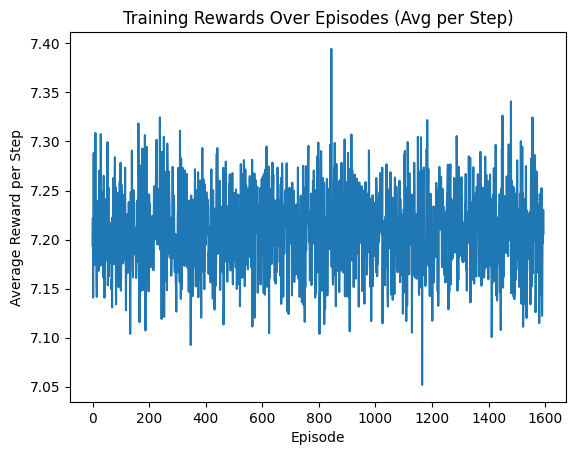


Evaluating RL Agent...
Average Reward per Step over 10 evaluation episodes: 7.2113
Action Distribution: {0: 0.0, 1: 0.3333333333333333, 2: 0.6666666666666666}
MAE: 7.2113, MSE: 52.0026, RMSE: 7.2113


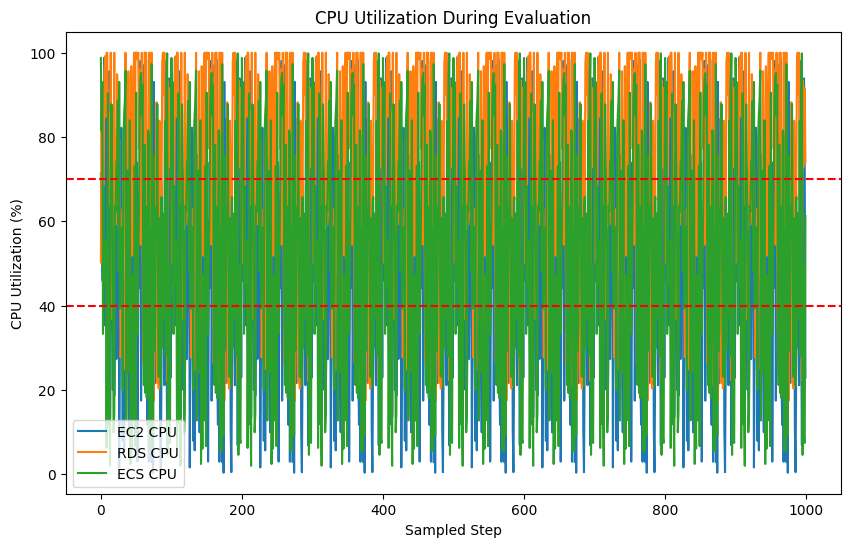


Input CPU Utilizations: EC2=30.0%, RDS=60.0%, ECS=90.0%
Predicted Actions: EC2=No Action (2), RDS=Scale Down (1), ECS=No Action (2)


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gym
from gym import spaces
import matplotlib.pyplot as plt

# 1. Updated Environment Class
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="../dataset scripts/reduced_ec2_data.csv", 
                 rds_file="../dataset scripts/reduced_rds_data.csv", 
                 ecs_file="../dataset scripts/reduced_ecs_data.csv"):
        df_ec2 = pd.read_csv(ec2_file)
        self.ec2_data = pd.to_numeric(df_ec2["EC2_CPUUtilization"], errors='coerce')
        self.ec2_data.fillna(self.ec2_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.ec2_data = self.ec2_data.values / 100.0

        df_rds = pd.read_csv(rds_file)
        self.rds_data = pd.to_numeric(df_rds["RDS_CPUUtilization"], errors='coerce')
        self.rds_data.fillna(self.rds_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.rds_data = self.rds_data.values / 100.0

        df_ecs = pd.read_csv(ecs_file)
        self.ecs_data = pd.to_numeric(df_ecs["ECS_CPUUtilization"], errors='coerce')
        self.ecs_data.fillna(self.ecs_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.ecs_data = self.ecs_data.values / 100.0

        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data), 1000)
        self.state_size = 9
        self.action_space = spaces.MultiDiscrete([3, 3, 3])
        self.ideal = np.array([0.5, 0.5, 0.5])
        self.lower_bound = np.array([0.4, 0.4, 0.4])
        self.upper_bound = np.array([0.7, 0.7, 0.7])
        
        self.index = 0
        self.effect = np.zeros(3)
        self.history = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(3)
        base_state = np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]])
        self.history = np.tile(np.clip(base_state + self.effect, 0, 1), 3)
        return self.history
    
    def step(self, action):
        current_state = np.clip(np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]]) + self.effect, 0, 1)
        
        new_effect = self.effect.copy()
        for i, act in enumerate(action):
            if act == 0:  # Scale Up => usage goes DOWN if usage > 0.5
                diff = current_state[i] - self.ideal[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff
                new_effect[i] -= adjustment
            elif act == 1:  # Scale Down => usage goes UP if usage < 0.5
                diff = self.ideal[i] - current_state[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff
                new_effect[i] += adjustment
        self.effect = new_effect * 0.95

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1

        base_state = np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]])
        next_state = np.clip(base_state + self.effect, 0, 1)
        self.history = np.concatenate((self.history[3:], next_state))
        
        error = np.mean(np.abs(next_state - self.ideal))
        threshold = 0.15
        if error <= threshold:
            base_reward = (threshold - error) * 80.0
        else:
            base_reward = -(error - threshold) * 10.0
        bonus = 4.0 if (np.all(next_state >= self.lower_bound) and np.all(next_state <= self.upper_bound)) else 0.0
        scale_actions = np.sum(action != 2)
        action_cost = -0.15 * scale_actions  # Reduced penalty for scaling
        no_action_bonus = 0.3 if np.all(action == 2) else 0.0  # Reduced bonus for No Action
        high_util_penalty = -0.5 if np.any(next_state > self.upper_bound) else 0.0  # Penalty for high utilization
        reward = base_reward + bonus + 8.0 + action_cost + no_action_bonus + high_util_penalty
        
        return self.history, reward, done

# 2. Define the Multi-Head DQN Network
class DQN(nn.Module):
    def __init__(self, state_size, hidden_dim=384):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.head_ec2 = nn.Linear(hidden_dim, 3)
        self.head_rds = nn.Linear(hidden_dim, 3)
        self.head_ecs = nn.Linear(hidden_dim, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_ec2 = self.head_ec2(x)
        q_rds = self.head_rds(x)
        q_ecs = self.head_ecs(x)
        return q_ec2, q_rds, q_ecs

# 3. Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_space = [0, 1, 2]
        self.memory = deque(maxlen=2000)
        self.gamma = 0.98
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99995
        self.learning_rate = 0.00025
        self.model = DQN(self.state_size).float()
        self.target_model = DQN(self.state_size).float()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.array([random.choice(self.action_space) for _ in range(3)])
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
        action_ec2 = torch.argmax(q_ec2, dim=1).item()
        action_rds = torch.argmax(q_rds, dim=1).item()
        action_ecs = torch.argmax(q_ecs, dim=1).item()
        return np.array([action_ec2, action_rds, action_ecs])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
            q_val = q_ec2[0, action[0]] + q_rds[0, action[1]] + q_ecs[0, action[2]]
            
            with torch.no_grad():
                next_q_ec2, next_q_rds, next_q_ecs = self.target_model(next_state_tensor)
                next_action_ec2 = torch.argmax(next_q_ec2, dim=1).item()
                next_action_rds = torch.argmax(next_q_rds, dim=1).item()
                next_action_ecs = torch.argmax(next_q_ecs, dim=1).item()
                next_val = (next_q_ec2[0, next_action_ec2] + 
                            next_q_rds[0, next_action_rds] + 
                            next_q_ecs[0, next_action_ecs])
                target = reward + (self.gamma * next_val.item() * (1 - int(done)))
            
            loss = self.criterion(q_val, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Main Training Loop
def train_rl_agent(episodes=5000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    rewards_history = []
    best_avg_reward = float('-inf')
    patience = 750
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step
        rewards_history.append(avg_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
        
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            patience = 750
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at episode {episode+1} with best reward: {best_avg_reward:.4f}")
                break
    
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")
    
    plt.plot(rewards_history)
    plt.title("Training Rewards Over Episodes (Avg per Step)")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward per Step")
    plt.show()
    return rewards_history

# 5. Evaluate the Trained RL Agent
def evaluate_rl_agent(episodes=10):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    agent.epsilon = 0.0
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    cpu_util_history = []
    sample_rate = 10
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            for a in action:
                action_counts[a] += 1
            if step % sample_rate == 0:
                cpu_util_history.append(next_state[6:9] * 100)
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over {episodes} evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    cpu_util_history = np.array(cpu_util_history)
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_util_history[:, 0], label="EC2 CPU")
    plt.plot(cpu_util_history[:, 1], label="RDS CPU")
    plt.plot(cpu_util_history[:, 2], label="ECS CPU")
    plt.axhline(40, color='r', linestyle='--')
    plt.axhline(70, color='r', linestyle='--')
    plt.title("CPU Utilization During Evaluation")
    plt.xlabel("Sampled Step")
    plt.ylabel("CPU Utilization (%)")
    plt.legend()
    plt.show()
    
    return overall_avg, action_distribution, mae, mse, rmse

# 6. Predict Scaling Actions
def predict_scaling_actions(cpu_utilizations):
    agent = DQNAgent(state_size=9)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    agent.epsilon = 0.0
    
    cpu_array = np.array(cpu_utilizations, dtype=np.float32)
    if np.max(cpu_array) > 1.0:
        cpu_array /= 100.0
    state = np.tile(cpu_array, 3)
    if len(state) != 9:
        raise ValueError("Input must have exactly 3 CPU values for [EC2, RDS, ECS].")
    state = np.clip(state, 0, 1)
    
    action = agent.act(state)
    action_map = {0: "Scale Up", 1: "Scale Down", 2: "No Action"}
    actions_desc = [action_map[a] for a in action]
    return action, actions_desc

if __name__ == "__main__":
    print("Training RL Agent...")
    train_rl_agent()
    print("\nEvaluating RL Agent...")
    evaluate_rl_agent()
    cpu_preds = [30.0, 60.0, 90.0]
    action, actions_desc = predict_scaling_actions(cpu_preds)
    print(f"\nInput CPU Utilizations: EC2={cpu_preds[0]}%, RDS={cpu_preds[1]}%, ECS={cpu_preds[2]}%")
    print(f"Predicted Actions: EC2={actions_desc[0]} ({action[0]}), RDS={actions_desc[1]} ({action[1]}), ECS={actions_desc[2]} ({action[2]})")

DeepSeek

Column ECS_NetworkIn not found in ECS CSV. Adding it with default zeros.
Episode 10/500, Total Reward: 260
Episode 20/500, Total Reward: 288
Episode 30/500, Total Reward: 276
Episode 40/500, Total Reward: 282
Episode 50/500, Total Reward: 272
Episode 60/500, Total Reward: 274
Episode 70/500, Total Reward: 290
Episode 80/500, Total Reward: 268
Episode 90/500, Total Reward: 288
Episode 100/500, Total Reward: 276
Episode 110/500, Total Reward: 280
Episode 120/500, Total Reward: 298
Episode 130/500, Total Reward: 280
Episode 140/500, Total Reward: 282
Episode 150/500, Total Reward: 266
Episode 160/500, Total Reward: 274
Episode 170/500, Total Reward: 282
Episode 180/500, Total Reward: 280
Episode 190/500, Total Reward: 288
Episode 200/500, Total Reward: 290
Episode 210/500, Total Reward: 282
Episode 220/500, Total Reward: 280
Episode 230/500, Total Reward: 274
Episode 240/500, Total Reward: 286
Episode 250/500, Total Reward: 286
Episode 260/500, Total Reward: 270
Episode 270/500, Total Rew

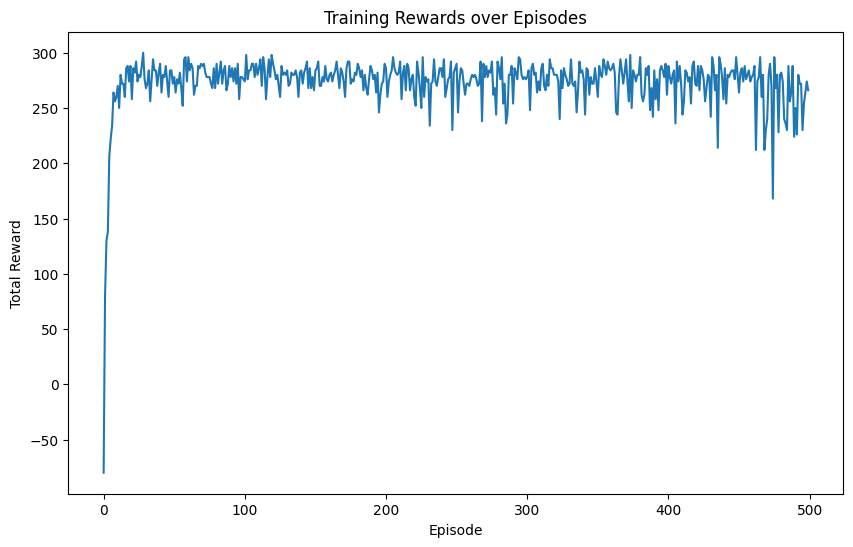

In [33]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

# =============================================================================
# 1. LSTM Model Definition
# =============================================================================

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.35):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# =============================================================================
# 2. Helper Function to Generate Lag Features
# =============================================================================

def add_lag_features(df, base_cols, num_lags):
    """
    For each column in base_cols, generate lag features.
    New columns are named as <col>_lag_<lag> for lag=1,...,num_lags.
    Rows with NaN (due to shifting) are dropped.
    """
    for col in base_cols:
        for lag in range(1, num_lags+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    return df

# =============================================================================
# 3. CSV-based LSTM Predictor with Separate Lag Counts and ECS Column Check
# =============================================================================

class LSTMPredictorCSV:
    """
    Loads CSV data for EC2, RDS, and ECS, generates lag features (with separate lag counts),
    and provides LSTM predictions using a sliding window.
    
    Parameters:
      - ec2_path, rds_path, ecs_path: Paths to CSV files.
      - ec2_base_cols, rds_base_cols, ecs_base_cols: List of base feature names.
      - ec2_num_lags, rds_num_lags, ecs_num_lags: Number of lag features to generate per base column.
      - sequence_length: Number of timesteps per input sequence.
      - ec2_model, rds_model, ecs_model: Pre-trained LSTM models.
      - device: torch.device to use.
    """
    def __init__(self, ec2_path, rds_path, ecs_path,
                 ec2_base_cols, rds_base_cols, ecs_base_cols,
                 ec2_num_lags, rds_num_lags, ecs_num_lags,
                 sequence_length, ec2_model, rds_model, ecs_model, device):
        # Load CSV data
        self.ec2_data = pd.read_csv(ec2_path, index_col=0)
        self.rds_data = pd.read_csv(rds_path, index_col=0)
        self.ecs_data = pd.read_csv(ecs_path, index_col=0)
        self.sequence_length = sequence_length
        self.device = device
        self.ec2_model = ec2_model
        self.rds_model = rds_model
        self.ecs_model = ecs_model
        
        # Store base columns and lag counts
        self.ec2_base_cols = ec2_base_cols
        self.rds_base_cols = rds_base_cols
        self.ecs_base_cols = ecs_base_cols
        self.ec2_num_lags = ec2_num_lags
        self.rds_num_lags = rds_num_lags
        self.ecs_num_lags = ecs_num_lags

        # For ECS, if a required base column is missing (e.g. 'ECS_NetworkIn'), add it with default value.
        for col in ecs_base_cols:
            if col not in self.ecs_data.columns:
                print(f"Column {col} not found in ECS CSV. Adding it with default zeros.")
                self.ecs_data[col] = 0.0

        # Generate lag features for each dataset
        self.ec2_data = add_lag_features(self.ec2_data, ec2_base_cols, ec2_num_lags)
        self.rds_data = add_lag_features(self.rds_data, rds_base_cols, rds_num_lags)
        self.ecs_data = add_lag_features(self.ecs_data, ecs_base_cols, ecs_num_lags)

        # Final input columns: base columns + generated lag columns
        self.ec2_input_cols = ec2_base_cols + [f'{col}_lag_{lag}' for col in ec2_base_cols for lag in range(1, ec2_num_lags+1)]
        self.rds_input_cols = rds_base_cols + [f'{col}_lag_{lag}' for col in rds_base_cols for lag in range(1, rds_num_lags+1)]
        self.ecs_input_cols = ecs_base_cols + [f'{col}_lag_{lag}' for col in ecs_base_cols for lag in range(1, ecs_num_lags+1)]
        self.reset()

    def reset(self):
        # Start from index = sequence_length to ensure a full window is available.
        self.index = self.sequence_length
        return

    def __call__(self):
        def get_sequence(data, input_cols, idx, seq_len):
            if idx > len(data):
                idx = seq_len
            seq = data[input_cols].iloc[idx - seq_len: idx].values
            return seq

        ec2_seq = get_sequence(self.ec2_data, self.ec2_input_cols, self.index, self.sequence_length)
        rds_seq = get_sequence(self.rds_data, self.rds_input_cols, self.index, self.sequence_length)
        ecs_seq = get_sequence(self.ecs_data, self.ecs_input_cols, self.index, self.sequence_length)

        # Convert sequences to torch tensors with shape (1, sequence_length, input_size)
        ec2_seq = torch.tensor(ec2_seq, dtype=torch.float32).unsqueeze(0).to(self.device)
        rds_seq = torch.tensor(rds_seq, dtype=torch.float32).unsqueeze(0).to(self.device)
        ecs_seq = torch.tensor(ecs_seq, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            ec2_pred = torch.sigmoid(self.ec2_model(ec2_seq)).item()
            rds_pred = torch.sigmoid(self.rds_model(rds_seq)).item()
            ecs_pred = torch.sigmoid(self.ecs_model(ecs_seq)).item()

        self.index += 1
        if self.index > len(self.ec2_data):
            self.index = self.sequence_length
        if self.index > len(self.rds_data):
            self.index = self.sequence_length
        if self.index > len(self.ecs_data):
            self.index = self.sequence_length

        return np.array([ec2_pred, rds_pred, ecs_pred])

# =============================================================================
# 4. Cloud Scaling Environment Definition
# =============================================================================

class CloudScalingEnv:
    """
    Environment for cloud resource scaling decisions.
    
    State: A 3-element numpy array representing LSTM predictions (for EC2, RDS, ECS)
           obtained from CSV data with lag features.
    
    Action: An integer (0-26) encoding a tuple of scaling decisions (each in {-1, 0, 1}).
    
    Reward: For each resource, if the prediction is:
            - >= 0.8, the optimal decision is +1.
            - <= 0.2, the optimal decision is -1.
            - Otherwise, optimal is 0.
            Total reward is the sum over resources.
    """
    def __init__(self, lstm_predictor, episode_length=100):
        self.lstm_predictor = lstm_predictor
        self.episode_length = episode_length
        self.current_step = 0
        self.state = None

    def reset(self):
        self.current_step = 0
        self.lstm_predictor.reset()
        self.state = self.lstm_predictor()
        return self.state

    def step(self, action):
        # Decode action (0-26) into a 3-tuple of scaling decisions.
        a = (action // 9) - 1
        b = ((action % 9) // 3) - 1
        c = (action % 3) - 1
        scaling_actions = (a, b, c)
        
        reward = 0
        for i, pred in enumerate(self.state):
            if pred >= 0.8:
                optimal = 1
            elif pred <= 0.2:
                optimal = -1
            else:
                optimal = 0
            reward += 1 if scaling_actions[i] == optimal else -1

        self.current_step += 1
        done = self.current_step >= self.episode_length
        self.state = self.lstm_predictor()
        return self.state, reward, done, {'scaling': scaling_actions}

# =============================================================================
# 5. DQN Agent and Replay Memory Definitions
# =============================================================================

class DQN(nn.Module):
    def __init__(self, state_size=3, action_size=27, hidden_size=64):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# =============================================================================
# 6. DQN Training Function
# =============================================================================

def train_dqn(env, num_episodes=500, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=300, target_update=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    memory = ReplayMemory(10000)
    steps_done = 0

    def select_action(state):
        nonlocal steps_done
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay)
        steps_done += 1
        if random.random() < epsilon:
            return random.randrange(27)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                q_values = policy_net(state_tensor)
                return q_values.argmax().item()

    episode_rewards = []
    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = select_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            memory.push(state, action, reward, next_state, done)
            state = next_state
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))
                state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
                action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
                reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)
                next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
                done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device)
                q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
                next_q_values = target_net(next_state_batch).max(1)[0].detach()
                expected_q_values = reward_batch + gamma * next_q_values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        episode_rewards.append(total_reward)
        if i_episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if (i_episode + 1) % 10 == 0:
            print(f"Episode {i_episode+1}/{num_episodes}, Total Reward: {total_reward}")
    return policy_net, episode_rewards

# =============================================================================
# 7. Main Training Loop
# =============================================================================

if __name__ == '__main__':
    # CSV file paths (ensure these are accessible)
    ec2_csv = "../dataset scripts/reduced_ec2_data.csv"
    rds_csv = "../dataset scripts/reduced_rds_data.csv"
    ecs_csv = "../dataset scripts/reduced_ecs_data.csv"
    
    # Define base columns for each dataset
    ec2_base_cols = ['EC2_CPUUtilization', 'EC2_MemoryUtilization', 'EC2_DiskWriteOps', 'EC2_NetworkIn']
    rds_base_cols = ['RDS_CPUUtilization', 'RDS_FreeableMemory', 'RDS_DatabaseConnections', 'RDS_WriteIOPS']
    # For ECS, we require 4 base columns to yield 28 features (4*(6+1)=28)
    ecs_base_cols = ['ECS_CPUUtilization', 'ECS_MemoryUtilization', 'ECS_RunningTaskCount', 'ECS_NetworkIn']
    
    # Set lag counts: For EC2 and RDS we use 7 lags (yielding 32 features), for ECS we use 6 lags (yielding 28 features)
    ec2_num_lags = 7
    rds_num_lags = 7
    ecs_num_lags = 6
    
    sequence_length = 10

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Update input sizes as expected by your trained LSTM models:
    ec2_input_size = 32
    rds_input_size = 32
    ecs_input_size = 28

    # Instantiate and load pre-trained LSTM models
    ec2_lstm = LSTMModel(input_size=ec2_input_size).to(device)
    rds_lstm = LSTMModel(input_size=rds_input_size).to(device)
    ecs_lstm = LSTMModel(input_size=ecs_input_size).to(device)

    ec2_lstm.load_state_dict(torch.load("../models/EC2_lstm_model.pth", map_location=device))
    rds_lstm.load_state_dict(torch.load("../models/RDS_lstm_model.pth", map_location=device))
    ecs_lstm.load_state_dict(torch.load("../models/ECS_lstm_model.pth", map_location=device))
    ec2_lstm.eval()
    rds_lstm.eval()
    ecs_lstm.eval()

    # Instantiate the CSV-based LSTM predictor with separate lag counts
    lstm_predictor = LSTMPredictorCSV(
        ec2_path=ec2_csv,
        rds_path=rds_csv,
        ecs_path=ecs_csv,
        ec2_base_cols=ec2_base_cols,
        rds_base_cols=rds_base_cols,
        ecs_base_cols=ecs_base_cols,
        ec2_num_lags=ec2_num_lags,
        rds_num_lags=rds_num_lags,
        ecs_num_lags=ecs_num_lags,
        sequence_length=sequence_length,
        ec2_model=ec2_lstm,
        rds_model=rds_lstm,
        ecs_model=ecs_lstm,
        device=device
    )

    # Create the environment using the predictor
    env = CloudScalingEnv(lstm_predictor, episode_length=100)
    
    # Train the DQN agent
    policy_net, rewards = train_dqn(env, num_episodes=500)
    
    # Plot training rewards
    plt.figure(figsize=(10,6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Rewards over Episodes")
    plt.show()


New grok

In [2]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

# =============================================================================
# 1. LSTM Model Definition
# =============================================================================

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.35):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# =============================================================================
# 2. Helper Function to Generate Lag Features
# =============================================================================

def add_lag_features(df, base_cols, num_lags):
    for col in base_cols:
        for lag in range(1, num_lags+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    return df

# =============================================================================
# 3. CSV-based LSTM Predictor with Fixed Train/Test Split and Prediction Logging
# =============================================================================

class LSTMPredictorCSV:
    def __init__(self, ec2_path, rds_path, ecs_path,
                 ec2_base_cols, rds_base_cols, ecs_base_cols,
                 ec2_num_lags, rds_num_lags, ecs_num_lags,
                 sequence_length, ec2_model, rds_model, ecs_model, device, test_size=0.2):
        self.ec2_data = pd.read_csv(ec2_path, index_col=0)
        self.rds_data = pd.read_csv(rds_path, index_col=0)
        self.ecs_data = pd.read_csv(ecs_path, index_col=0)
        self.sequence_length = sequence_length
        self.device = device
        self.ec2_model = ec2_model
        self.rds_model = rds_model
        self.ecs_model = ecs_model
        
        self.ec2_base_cols = ec2_base_cols
        self.rds_base_cols = rds_base_cols
        self.ecs_base_cols = ecs_base_cols
        self.ec2_num_lags = ec2_num_lags
        self.rds_num_lags = rds_num_lags
        self.ecs_num_lags = ecs_num_lags

        for col in ecs_base_cols:
            if col not in self.ecs_data.columns:
                raise ValueError(f"Column {col} not found in ECS CSV. Please ensure all required columns are present.")

        self.ec2_data = add_lag_features(self.ec2_data, ec2_base_cols, ec2_num_lags)
        self.rds_data = add_lag_features(self.rds_data, rds_base_cols, rds_num_lags)
        self.ecs_data = add_lag_features(self.ecs_data, ecs_base_cols, ecs_num_lags)

        self.ec2_input_cols = ec2_base_cols + [f'{col}_lag_{lag}' for col in ec2_base_cols for lag in range(1, ec2_num_lags+1)]
        self.rds_input_cols = rds_base_cols + [f'{col}_lag_{lag}' for col in rds_base_cols for lag in range(1, rds_num_lags+1)]
        self.ecs_input_cols = ecs_base_cols + [f'{col}_lag_{lag}' for col in ecs_base_cols for lag in range(1, ecs_num_lags+1)]
        
        # Fixed train/test split
        self.ec2_indices = np.random.permutation(len(self.ec2_data))
        self.ec2_train_indices = self.ec2_indices[:int((1-test_size) * len(self.ec2_data))]
        self.ec2_test_indices = self.ec2_indices[int((1-test_size) * len(self.ec2_data)):]
        self.rds_indices = np.random.permutation(len(self.rds_data))
        self.rds_train_indices = self.rds_indices[:int((1-test_size) * len(self.rds_data))]
        self.rds_test_indices = self.rds_indices[int((1-test_size) * len(self.rds_data)):]
        self.ecs_indices = np.random.permutation(len(self.ecs_data))
        self.ecs_train_indices = self.ecs_indices[:int((1-test_size) * len(self.ecs_data))]
        self.ecs_test_indices = self.ecs_indices[int((1-test_size) * len(self.ecs_data)):]

        # Prediction logging
        self.train_predictions = {'ec2': [], 'rds': [], 'ecs': []}
        self.test_predictions = {'ec2': [], 'rds': [], 'ecs': []}
        self.train_mode = True
        self.reset()

    def reset(self):
        self.index = self.sequence_length
        return

    def __call__(self):
        def get_sequence(data, input_cols, indices, idx, seq_len):
            if idx >= len(indices):
                idx = seq_len
            start_idx = indices[idx - seq_len: idx] if idx - seq_len >= 0 else indices[:idx]
            seq = data[input_cols].iloc[start_idx].values
            return seq

        indices = (self.ec2_train_indices if self.train_mode else self.ec2_test_indices,
                   self.rds_train_indices if self.train_mode else self.rds_test_indices,
                   self.ecs_train_indices if self.train_mode else self.ecs_test_indices)
        data = (self.ec2_data, self.rds_data, self.ecs_data)
        input_cols = (self.ec2_input_cols, self.rds_input_cols, self.ecs_input_cols)

        seqs = [get_sequence(data[i], input_cols[i], indices[i], self.index, self.sequence_length) for i in range(3)]
        seqs = [torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(self.device) for seq in seqs]

        with torch.no_grad():
            preds = [torch.sigmoid(self.ec2_model(seqs[0])).item(),
                     torch.sigmoid(self.rds_model(seqs[1])).item(),
                     torch.sigmoid(self.ecs_model(seqs[2])).item()]

        # Log predictions
        pred_dict = self.train_predictions if self.train_mode else self.test_predictions
        pred_dict['ec2'].append(preds[0])
        pred_dict['rds'].append(preds[1])
        pred_dict['ecs'].append(preds[2])

        # Add noise during training
        if self.train_mode:
            preds = [p + np.random.normal(0, 0.05) for p in preds]
            preds = [max(0, min(1, p)) for p in preds]

        self.index += 1
        return np.array(preds)

    def set_eval_mode(self):
        self.train_mode = False
        self.reset()

# =============================================================================
# 4. Cloud Scaling Environment Definition
# =============================================================================

class CloudScalingEnv:
    def __init__(self, lstm_predictor, episode_length=100):
        self.lstm_predictor = lstm_predictor
        self.episode_length = episode_length
        self.current_step = 0
        self.state = None

    def reset(self):
        self.current_step = 0
        self.lstm_predictor.reset()
        self.state = self.lstm_predictor()
        return self.state

    def step(self, action):
        a = (action // 9) - 1
        b = ((action % 9) // 3) - 1
        c = (action % 3) - 1
        scaling_actions = (a, b, c)
        
        reward = 0
        for i, pred in enumerate(self.state):
            if pred >= 0.9:  # Adjusted threshold
                optimal = 1
            elif pred <= 0.1:  # Adjusted threshold
                optimal = -1
            else:
                optimal = 0
            reward += 1.0 if scaling_actions[i] == optimal else -1.0

        self.current_step += 1
        done = self.current_step >= self.episode_length
        self.state = self.lstm_predictor()
        return self.state, reward, done, {'scaling': scaling_actions}

# =============================================================================
# 5. DQN Agent and Replay Memory Definitions
# =============================================================================

class DQN(nn.Module):
    def __init__(self, state_size=3, action_size=27, hidden_size=128):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# =============================================================================
# 6. DQN Training Function with Double DQN
# =============================================================================

def train_dqn(env, num_episodes=1500, batch_size=256, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=3000, target_update=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = ReplayMemory(10000)
    steps_done = 0

    def select_action(state):
        nonlocal steps_done
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay)
        steps_done += 1
        if random.random() < epsilon:
            return random.randrange(27)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                q_values = policy_net(state_tensor)
                return q_values.argmax().item()

    episode_rewards = []
    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = select_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            memory.push(state, action, reward, next_state, done)
            state = next_state
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))
                state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
                action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
                reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)
                next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
                done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device)

                with torch.no_grad():
                    next_q_values = target_net(next_state_batch)
                    next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)
                    next_q_values = next_q_values.gather(1, next_actions).squeeze()

                q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
                expected_q_values = reward_batch + gamma * next_q_values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        episode_rewards.append(total_reward)
        if i_episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if (i_episode + 1) % 10 == 0:
            print(f"Episode {i_episode+1}/{num_episodes}, Total Reward: {total_reward}")
    return policy_net, episode_rewards

# =============================================================================
# 7. Main Training Loop with Evaluation and Prediction Analysis
# =============================================================================

if __name__ == '__main__':
    ec2_csv = "../dataset scripts/reduced_ec2_data.csv"
    rds_csv = "../dataset scripts/reduced_rds_data.csv"
    ecs_csv = "../dataset scripts/reduced_ecs_data.csv"
    
    ec2_base_cols = ['EC2_CPUUtilization', 'EC2_MemoryUtilization', 'EC2_DiskWriteOps', 'EC2_NetworkIn']
    rds_base_cols = ['RDS_CPUUtilization', 'RDS_FreeableMemory', 'RDS_DatabaseConnections', 'RDS_WriteIOPS']
    ecs_base_cols = ['ECS_CPUUtilization', 'ECS_MemoryUtilization', 'ECS_RunningTaskCount', 'ECS_NetworkIn']
    
    ec2_num_lags = 7
    rds_num_lags = 7
    ecs_num_lags = 6
    
    sequence_length = 10

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    ec2_input_size = 32
    rds_input_size = 32
    ecs_input_size = 28

    ec2_lstm = LSTMModel(input_size=ec2_input_size).to(device)
    rds_lstm = LSTMModel(input_size=rds_input_size).to(device)
    ecs_lstm = LSTMModel(input_size=ecs_input_size).to(device)

    ec2_lstm.load_state_dict(torch.load("../models/LSTMv5/ec2_lstm_model_improved.pth", map_location=device))
    rds_lstm.load_state_dict(torch.load("../models/LSTMv5/rds_lstm_model_improved.pth", map_location=device))
    ecs_lstm.load_state_dict(torch.load("../models/LSTMv5/ecs_lstm_model_improved.pth", map_location=device))
    ec2_lstm.eval()
    rds_lstm.eval()
    ecs_lstm.eval()

    lstm_predictor = LSTMPredictorCSV(
        ec2_path=ec2_csv, rds_path=rds_csv, ecs_path=ecs_csv,
        ec2_base_cols=ec2_base_cols, rds_base_cols=rds_base_cols, ecs_base_cols=ecs_base_cols,
        ec2_num_lags=ec2_num_lags, rds_num_lags=rds_num_lags, ecs_num_lags=ecs_num_lags,
        sequence_length=sequence_length, ec2_model=ec2_lstm, rds_model=rds_lstm, ecs_model=ecs_lstm,
        device=device
    )

    env = CloudScalingEnv(lstm_predictor, episode_length=100)
    
    policy_net, rewards = train_dqn(env, num_episodes=1500)
    
    plt.figure(figsize=(10,6))
    plt.plot(rewards, label='Raw Rewards', alpha=0.5)
    moving_avg = pd.Series(rewards).rolling(window=50).mean()
    plt.plot(moving_avg, label='Moving Average (window=50)', color='red')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Rewards over Episodes")
    plt.legend()
    plt.show()

    # Evaluation on test set
    lstm_predictor.set_eval_mode()
    env = CloudScalingEnv(lstm_predictor, episode_length=100)
    env.reset()
    total_eval_reward = 0
    for _ in range(100):
        state = env.lstm_predictor()
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = policy_net(state_tensor).argmax().item()
        next_state, reward, done, _ = env.step(action)
        total_eval_reward += reward
    print(f"Average Evaluation Reward: {total_eval_reward / 100}")

    # Analyze prediction distributions
    print("\nPrediction Distribution Analysis:")
    for key in ['ec2', 'rds', 'ecs']:
        train_preds = np.array(lstm_predictor.train_predictions[key])
        test_preds = np.array(lstm_predictor.test_predictions[key])
        print(f"\n{key.upper()} Predictions:")
        print(f"Train Mean: {train_preds.mean():.3f}, Std: {train_preds.std():.3f}")
        print(f"Test Mean: {test_preds.mean():.3f}, Std: {test_preds.std():.3f}")
        print(f"Train % in [0.1, 0.9]: {np.mean((train_preds > 0.1) & (train_preds < 0.9)):.3f}")
        print(f"Test % in [0.1, 0.9]: {np.mean((test_preds > 0.1) & (test_preds < 0.9)):.3f}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL sklearn.preprocessing._data.RobustScaler was not an allowed global by default. Please use `torch.serialization.add_safe_globals([RobustScaler])` or the `torch.serialization.safe_globals([RobustScaler])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.